# Exercise 06 Convolutional Neural Networks

In this exercise, you need to follow the requirements of each question to generate the Python code, and the following example is for reference：

- Sample Question: Write a program that takes the user's name as input and prints "Hello, [name]!" where [name] is the user's input.

- Potential Answer:

```python
    name = input("Enter your name: ")
    print("Hello, " + name + "!")
```
- If you enter 'David', the code will output 'Hello, David!', and this will satisfy the requirements.

## Attention
- Generally, there will be multiple answers for one question and you don't have to strictly follow the instructions in the tutorial, as long as you can make the output of the code meet the requirements of the question.
- If possible, strive to make your code concise and avoid excessive reliance on less commonly used libraries.
- You may need to search for information on the Internet to complete the excercise.

### Question 01: Please build a ResNet-18 model based on the code in the tutorial to classify the images in the 'data' folder. Modify the relevant parameters from the tutorial such as learning rate, batch size, optimizer, number of epochs, loss function, etc., to achieve a better model than the one in the tutorial. Additionally, Please add some code to the original code to record the train loss and validation loss for each epoch. Then, plot them on a graph together.

### Write your answer in the following code frame:

In [1]:
from torchvision import models
import torch.nn as nn

def model_A(num_classes):
    # pretrained = True means we use the pretrained parameters of ResNet18
    model_resnet = models.resnet18(pretrained=True)
    num_features = model_resnet.fc.in_features # The input channels of the full connection layer
    model_resnet.fc = nn.Linear(num_features, num_classes) # We modify the number of classes
    # We only train the full connection layer (fine-tune)
    for param in model_resnet.parameters():
        param.requires_grad = False
    for param in model_resnet.fc.parameters():
        param.requires_grad = True
    return model_resnet

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

## Note that: here we provide a basic solution for loading data and transforming data.
## You can directly change it if you find something wrong or not good enough.

## the mean and standard variance of imagenet dataset
## mean_vals = [0.485, 0.456, 0.406]
## std_vals = [0.229, 0.224, 0.225]

def load_data(data_dir = "./data/",input_size = 224,batch_size = 36):
    # data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size), # Resize to 224 * 224
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    ## Load dataset
    ## For other tasks, you may need to modify the data dir or even rewrite some part of 'data.py'
    image_dataset_train = datasets.ImageFolder(os.path.join(data_dir, '2-Medium-Scale'), data_transforms['train'])
    image_dataset_valid = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])

    train_loader = DataLoader(image_dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(image_dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, valid_loader

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

## Note that: here we provide a basic solution for training and validation.
## You can directly change it if you find something wrong or not good enough.

def train_model(model,train_loader, valid_loader, criterion, optimizer, num_epochs=20):

    def train(model, train_loader,optimizer,criterion):
        model.train(True)
        total_loss = 0.0
        total_correct = 0

        for inputs, labels in train_loader:
            # send the data to device (GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) # prediction
            loss = criterion(outputs, labels) # loss
            _, predictions = torch.max(outputs, 1) # The class with maximal probability
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(predictions == labels.data)

        epoch_loss = total_loss / len(train_loader.dataset)
        epoch_acc = total_correct.double() / len(train_loader.dataset)
        return epoch_loss, epoch_acc.item()

    def valid(model, valid_loader,criterion):
        model.train(False)
        total_loss = 0.0
        total_correct = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predictions = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(predictions == labels.data)
        epoch_loss = total_loss / len(valid_loader.dataset)
        epoch_acc = total_correct.double() / len(valid_loader.dataset)
        return epoch_loss, epoch_acc.item()
    
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('*' * 100)
        print('epoch:{:d}/{:d}'.format(epoch, num_epochs))
        train_loss, train_acc = train(model, train_loader,optimizer,criterion)
        print("training: loss:   {:.4f}, accuracy: {:.4f}".format(train_loss, train_acc))
        valid_loss, valid_acc = valid(model, valid_loader,criterion)
        print("validation: loss: {:.4f}, accuracy: {:.4f}".format(valid_loss, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        # save the best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

In [19]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
train_losses = []
valid_losses = []
## about model
num_classes = 10

## about data
data_dir = "data" ## You may need to specify the data_dir first
inupt_size = 224
batch_size = 24

## about training
num_epochs = 35
lr = 0.0025

## model initialization
model = model_A(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)
model = model.to(device)

## optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999))
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
## loss function
criterion = nn.CrossEntropyLoss()

## data preparation
train_loader, valid_loader = load_data(data_dir=data_dir,input_size=inupt_size, batch_size=batch_size)
# train
train_model(model,train_loader, valid_loader, criterion, optimizer, num_epochs=num_epochs)


d:\Anaconda\envs\optimization\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\optimization\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device: cpu
****************************************************************************************************
epoch:0/35
training: loss:   1.9893, accuracy: 0.2820
validation: loss: 1.4177, accuracy: 0.6100
****************************************************************************************************
epoch:1/35
training: loss:   1.2775, accuracy: 0.6000
validation: loss: 1.0434, accuracy: 0.6700
****************************************************************************************************
epoch:2/35
training: loss:   1.0110, accuracy: 0.6920
validation: loss: 0.9032, accuracy: 0.6600
****************************************************************************************************
epoch:3/35
training: loss:   0.9488, accuracy: 0.6900
validation: loss: 0.7543, accuracy: 0.7300
****************************************************************************************************
epoch:4/35
training: loss:   0.8125, accuracy: 0.7400
validation: loss: 0.7250, accuracy: 0.770

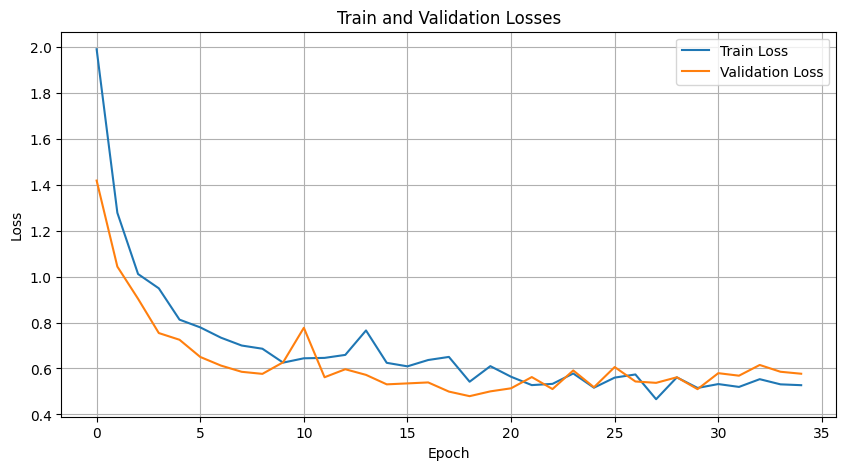

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
#plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid()
plt.show()